In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from operator import attrgetter
from category_encoders.target_encoder import TargetEncoder

from my_modules.plot_and_stat_funcs import *

warnings.filterwarnings("ignore")

In [2]:
store = pd.read_csv('data/store_transformed.csv')
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv').target

In [3]:
train_sales = X_train.copy()
train_sales['target'] = y_train

# Analysis of the new features

## Some relations between the features

As the rows where Open equals 0 were removed and some features were encoded let's see how the new features look like.

The correlation matrix between all the features

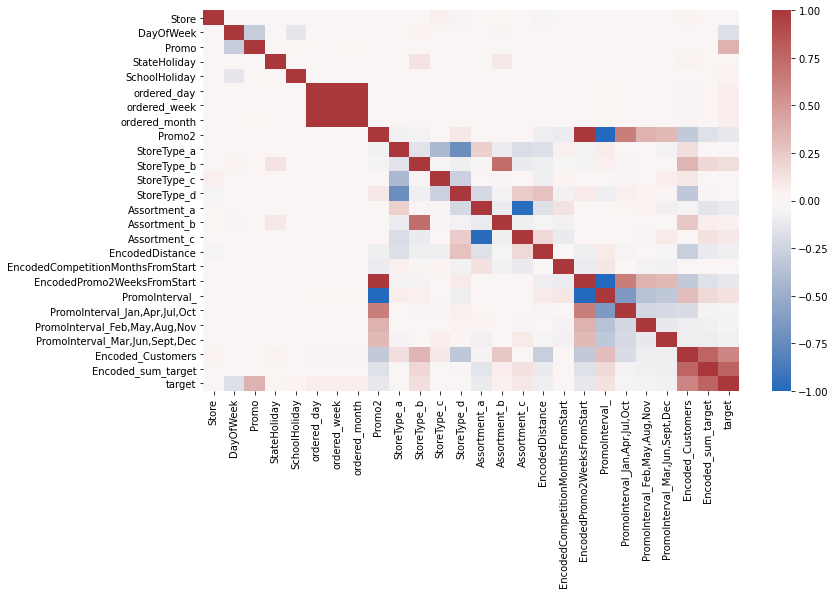

In [4]:
plt.figure(figsize=(12, 7))
sns.heatmap(train_sales.corr(), cmap='vlag', vmin=-1, vmax=1)
plt.show()

As you can see there are some "clusters" of bright cells. But in all of them the correlation is between features used for encoding the same old feature. For example the big red square. It means that the correlation between the ordered number of day, week and month is high which is obviously. The big bright square almost at the right bottom corner and bright lines for **Promo2** mean that the correlation between "promo" features is high. Also if some features are sparse, the correlation between them is high. For example **StoreType_b** and **Assortment_b**.

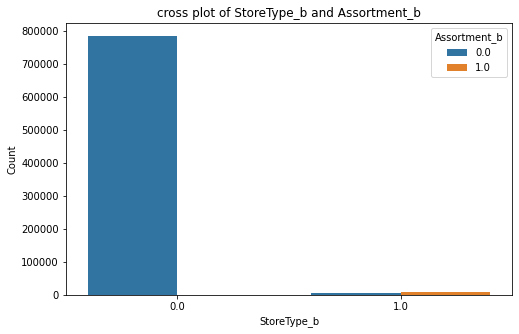

In [5]:
cross_bar_plot(train_sales, col_x='StoreType_b', col_hue='Assortment_b', figsize=(8, 5))

Almost all the values of these features are (0, 0). So the correlation between them is high.  
There is a correlation between **DayOfWeek** and **Promo**.

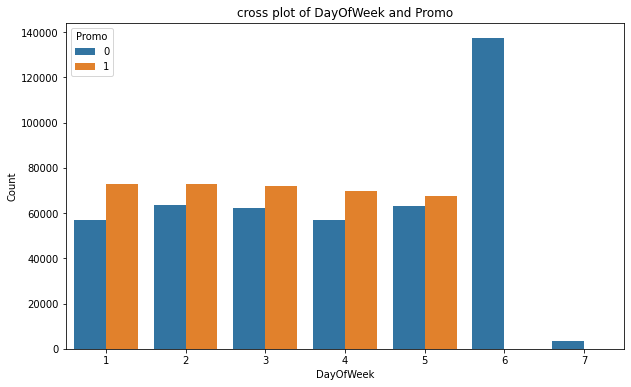

In [6]:
cross_bar_plot(train_sales, 'DayOfWeek', 'Promo')

If **DayOfWeek** equal 6 or 7, **Promo** equals 0 in all cases. Otherwise **Promo** takes 0 or 1 with some probability similar for each **DayOfWeek**.

But the correlation between features and target is very low. It means that there is not linear dependency between them.

The count of days between the start and end of history.

In [7]:
train_sales.ordered_day.max() - train_sales.ordered_day.min() + 1

894

The number of unique days in the table

In [8]:
train_sales.ordered_day.nunique()

894

So all the days in the old table are present here. But for some stores there are days that are absent in the table. For example the history of store with id = 1

In [9]:
train_sales[train_sales.Store == 1].target.size

740

It should be considered when dividing the table into time series.

For this purpose create the dataframe with all the days in the history.

In [10]:
all_days = train_sales.ordered_day.unique()
all_days.sort()
all_days = pd.DataFrame({'ordered_day': all_days})

## Researching time series

Let's see the mean monthly sales.

### Mean sales

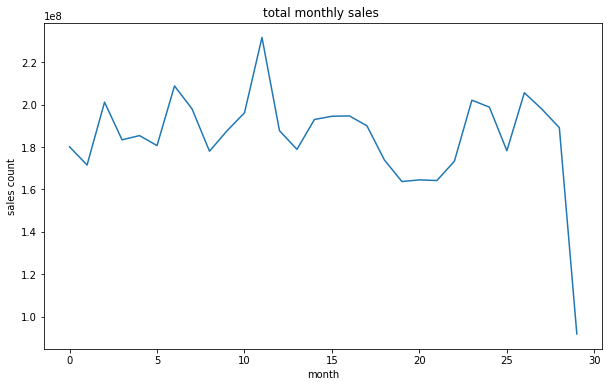

In [11]:
plot_time_series(train_sales, time_range='month')

There is an increasing trend and two pikes in decembers. It might mean that the time series for the most of stores have the same view.

Let's see the time series of means sales for different categories.  
I will show time series of mean monthly sales because some classes are imbalanced and the total sales can differ due to this.

### Assortment

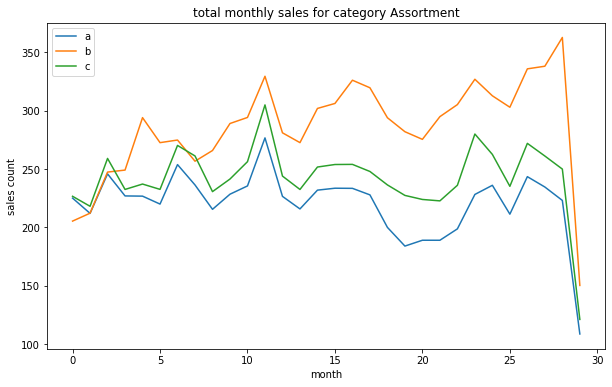

In [12]:
my_plot_time_series_of_encoded_cat(train_sales, 'Assortment', time_range='month')

There is obvious difference in sales count between assortment categories. Moreover the sales for category 'b' has an increasing trend. It might mean that the stores of this category has the same.

As in this category there are few stores let's plot time series for all of them.

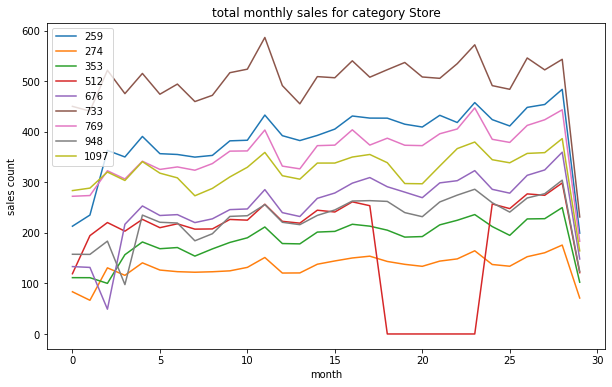

In [13]:
plot_time_series_of_cat(train_sales[train_sales.Assortment_b == 1], 'Store')

Almost all of them has an increasing trend. The store with id equals 512 has some months without sales. It should also be considered when working with time series.

### StoreType

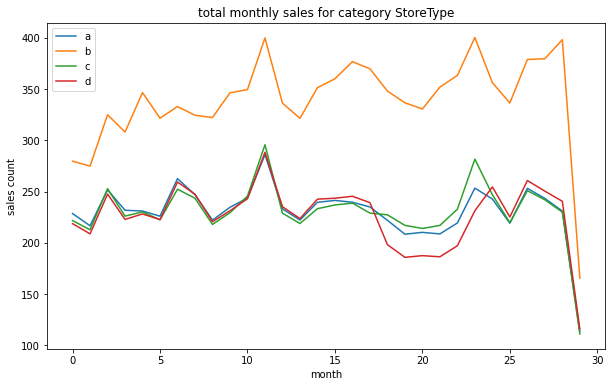

In [14]:
my_plot_time_series_of_encoded_cat(train_sales, 'StoreType')

The stores of type 'b' have an increasing trend and the higher mean sales count while others have almost the same count.

### PromoInterval

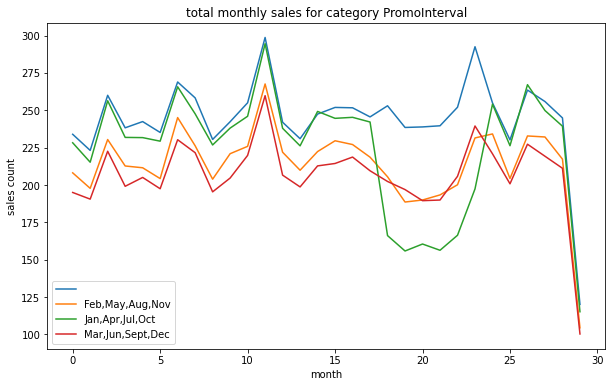

In [15]:
my_plot_time_series_of_encoded_cat(train_sales, 'PromoInterval')

Here the stores that don't participate in Promo2 (and don't have **PromoInterval** feature) have the higher mean sales among others.

### Promo

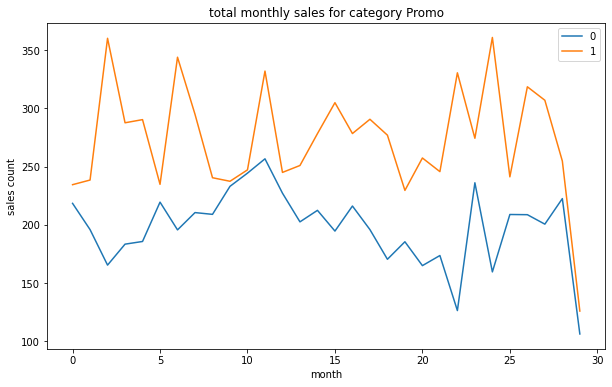

In [16]:
plot_time_series_of_cat(train_sales, 'Promo')

The mean sales in 'promo' days are higher than in common ones. It means that promotions work and increase the sales. Let's see the total monthly sales for this category.

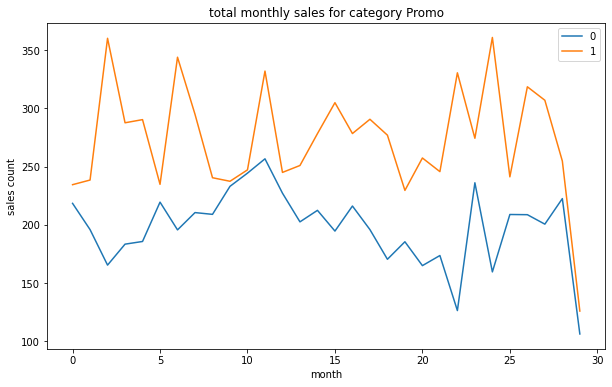

In [17]:
plot_time_series_of_cat(train_sales, 'Promo')

Generally in promo days even the total sales is higher. So this category affects the mean and total sales count.

### StateHoliday

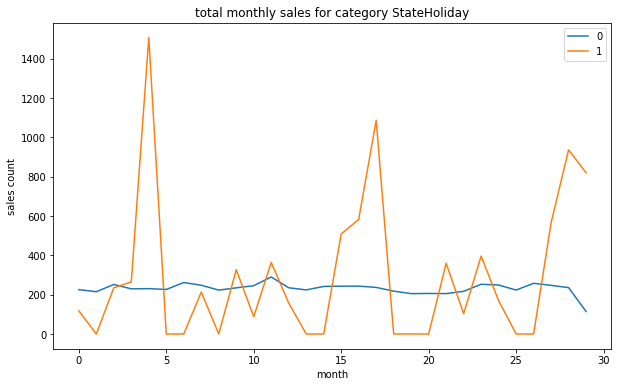

In [18]:
plot_time_series_of_cat(train_sales, 'StateHoliday')

There are some "empty" months. But when value is greater than zero it is mostly greater than the mean sales of the other months.

### SchoolHoliday

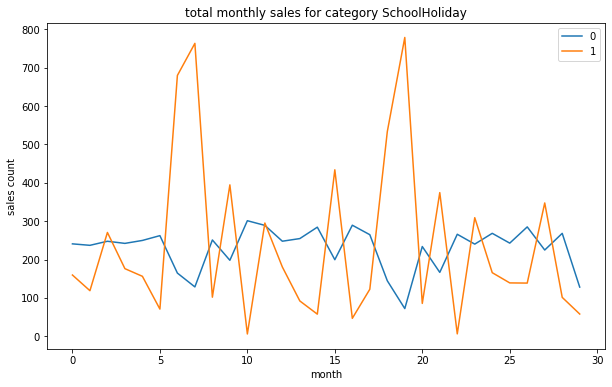

In [19]:
plot_time_series_of_cat(train_sales, 'SchoolHoliday')

The mean sales in school holidays is generally higher than in common days.

### DayOfWeek

Here are time series for different days of week.

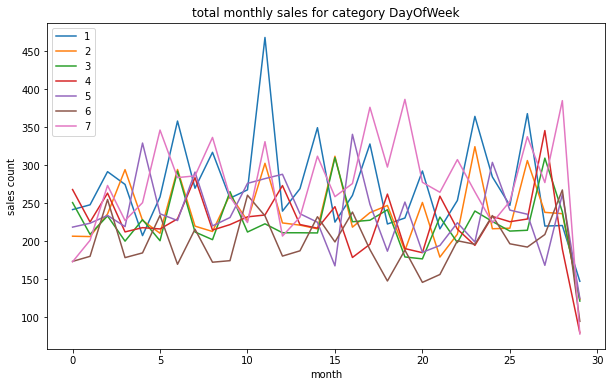

In [20]:
plot_time_series_of_cat(train_sales, 'DayOfWeek')

It's hard to say what day have the most sales count. Maybe because is each month the number of weeks is not integer and therefore the number of days of week is different.

### Promo2

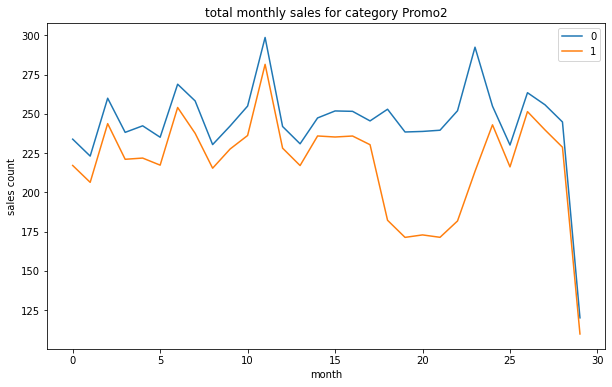

In [21]:
plot_time_series_of_cat(train_sales, 'Promo2')

The mean sales of stores that participate in Promo2 is lower than in the others.

### Some special time series

Here are some monthly sales of different stores

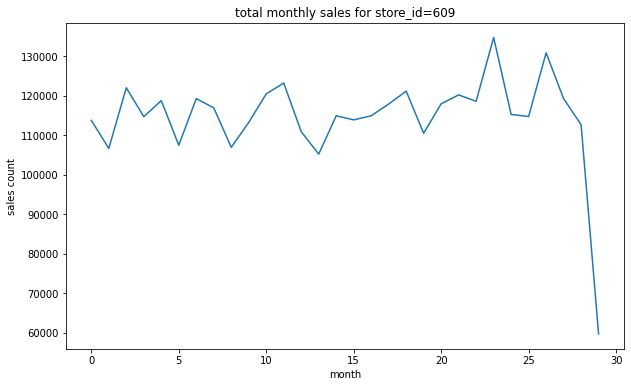

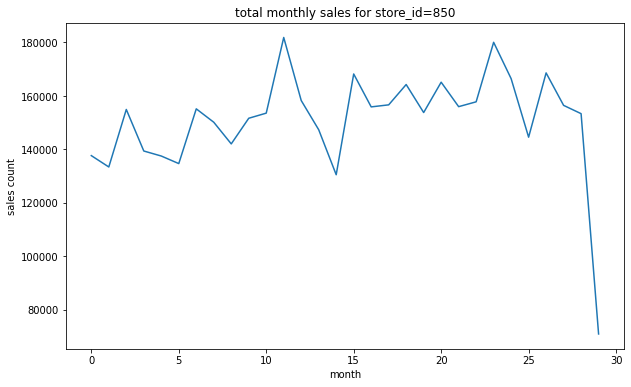

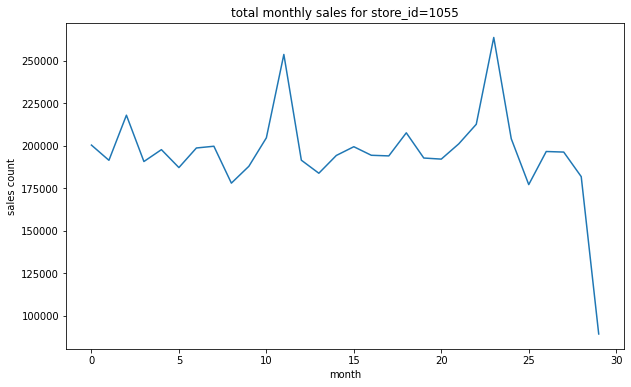

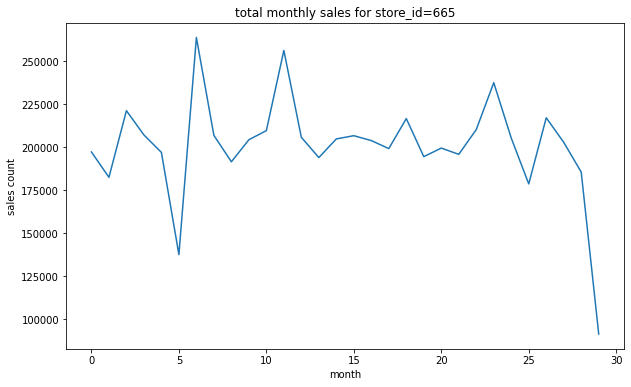

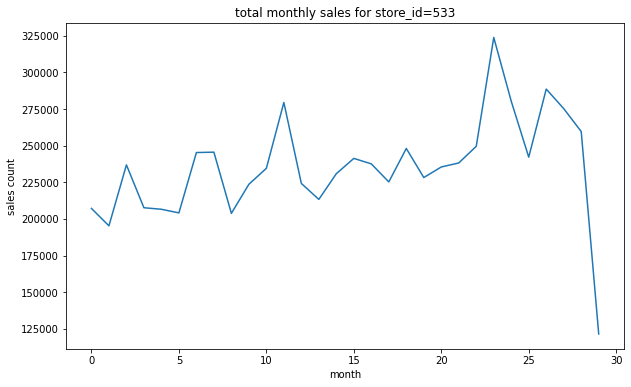

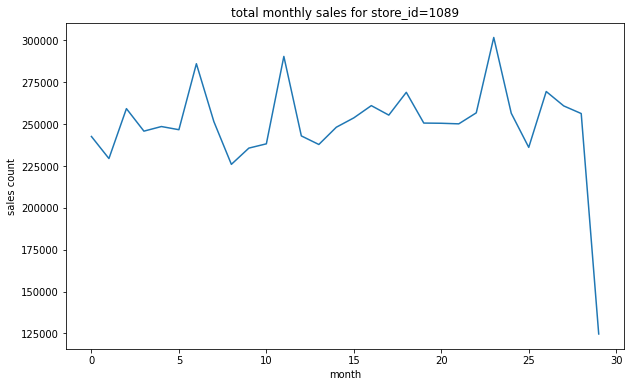

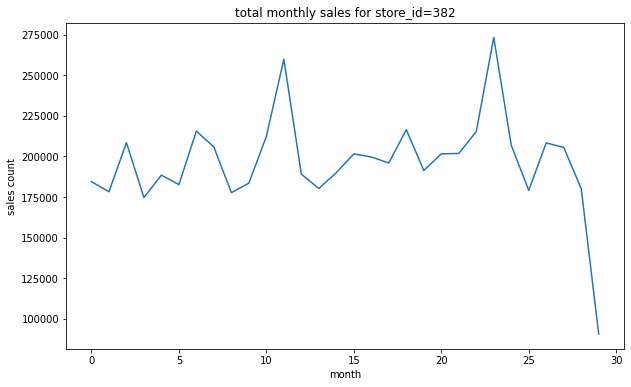

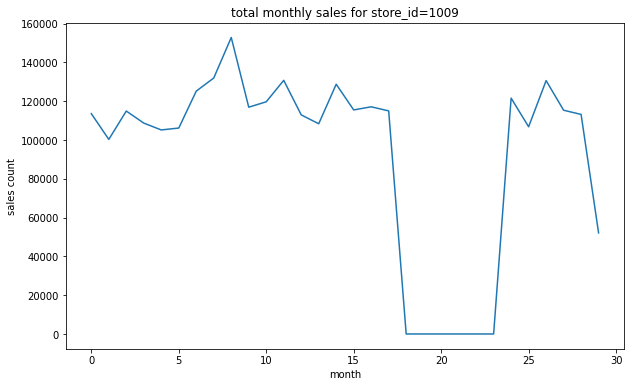

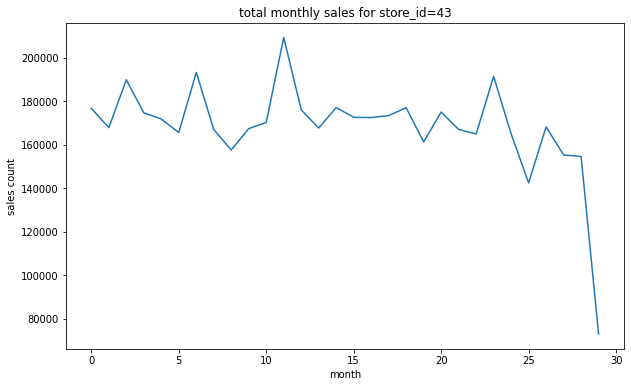

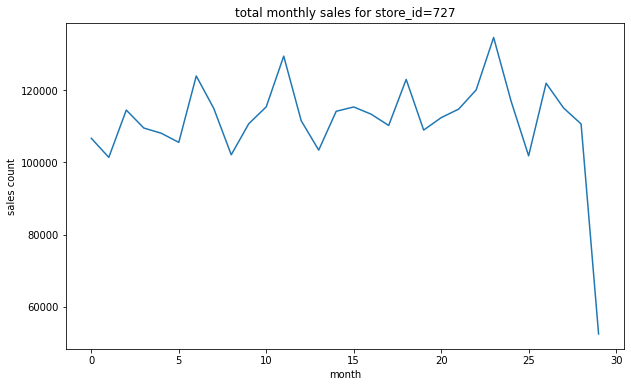

In [22]:
for store_id in store.Store.sample(10, random_state=450):
    plot_time_series(train_sales, store_id, 'month')

One of them has a few months when the turnover equals 0. Some of them have increasing trend, some of them don't have any trend. Let's take a look at weekly sales of other stores.

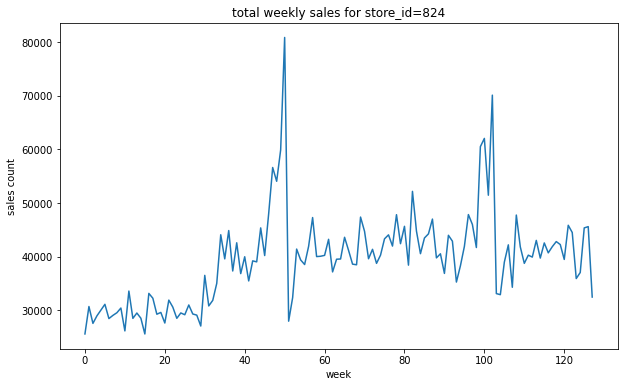

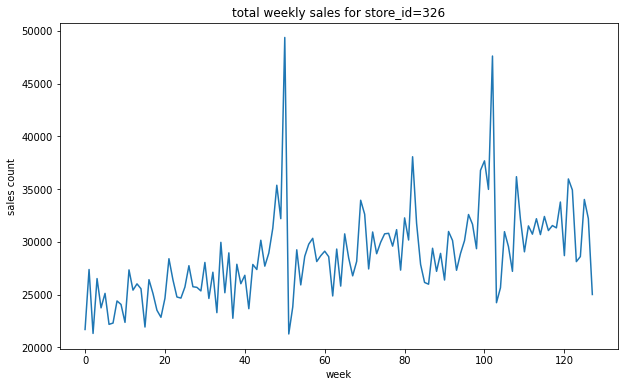

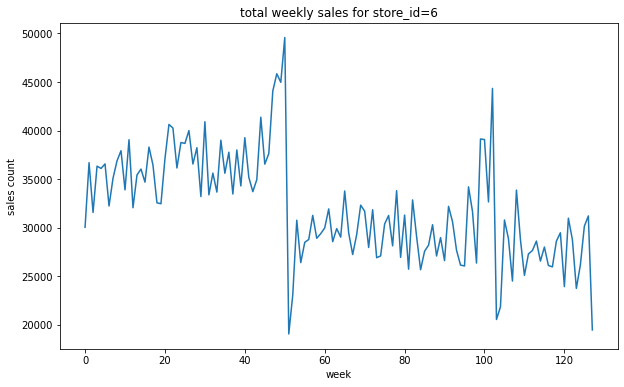

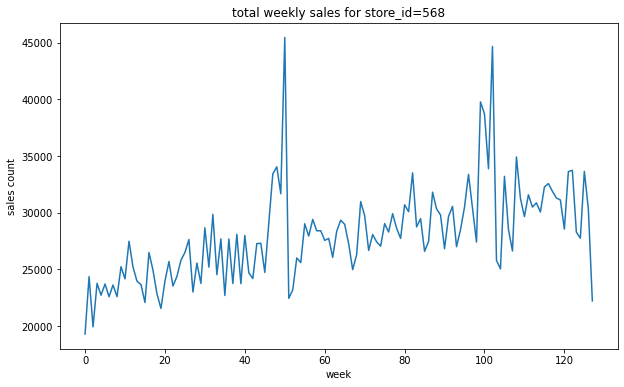

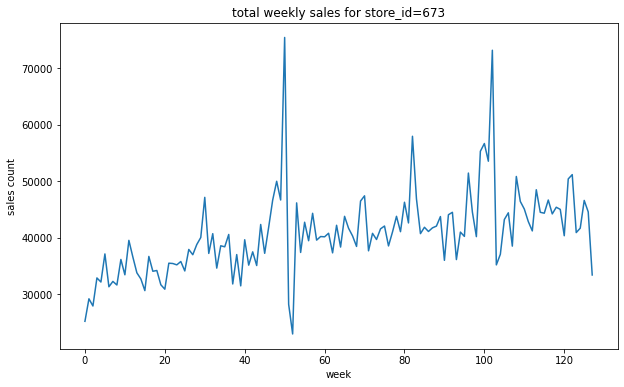

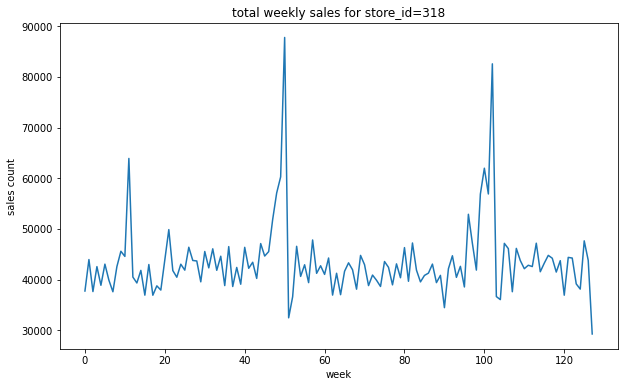

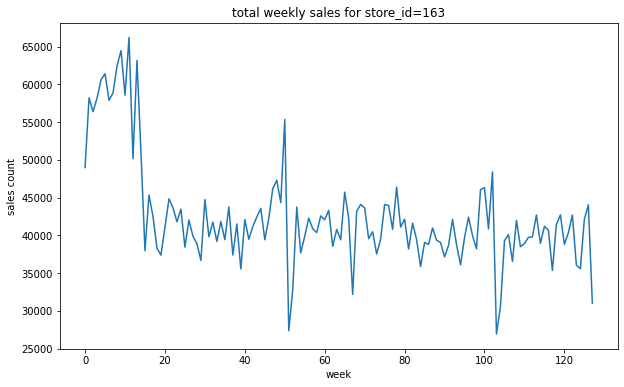

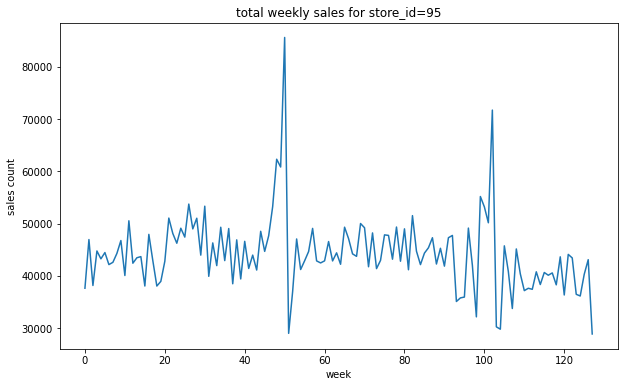

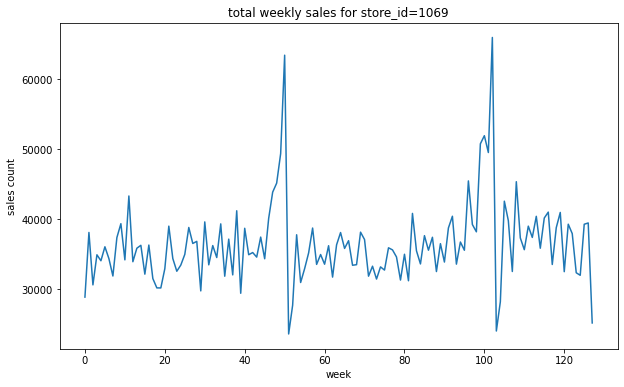

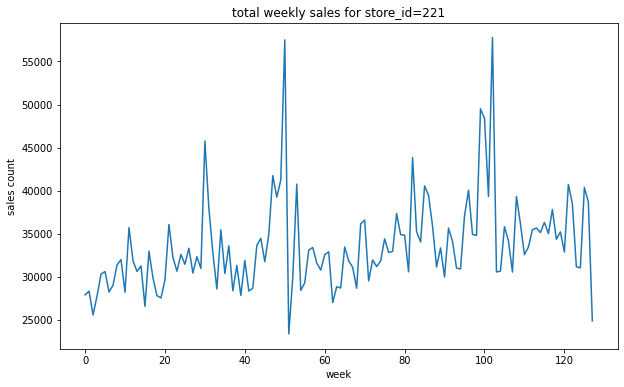

In [23]:
for store_id in store.Store.sample(10, random_state=298):
    plot_time_series(train_sales, store_id, 'week')

The most of these graphics have pikes near by the december weeks. It can be explained by the greater demand before New Year. Some of them have increasing trend, some of them don't have any trend. So these series are common in having pikes near by New Year.

Let's see the total weekly and monthly sales

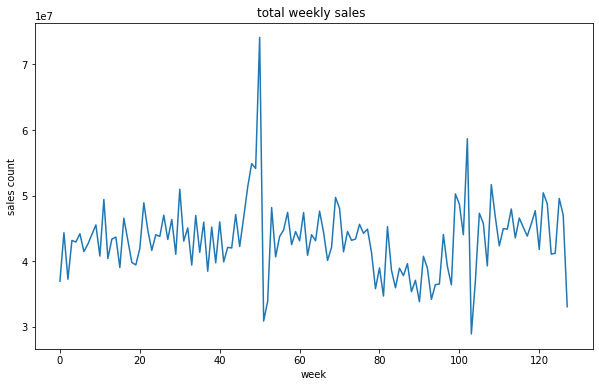

In [24]:
plot_time_series(train_sales, time_range='week', agg_func='sum')

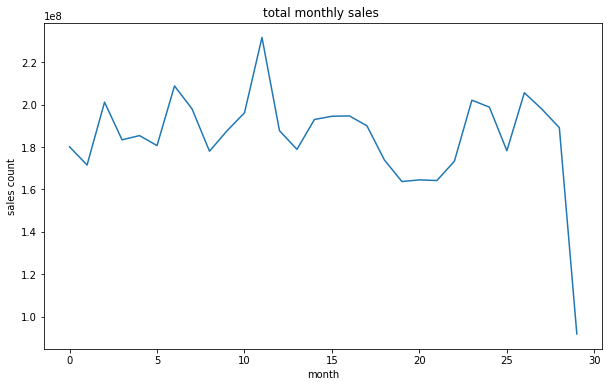

In [25]:
plot_time_series(train_sales, time_range='month', agg_func='sum')

The last value is very low. It is explained by that the last day in the train dataset is not the last day of month.

The time series doesn't have any trend.